<a href="https://colab.research.google.com/github/bogsin/CP-1/blob/main/CP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os.path import splitext, basename
from keras.models import model_from_json
import pytesseract
import glob

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def load_model(path):
    path = splitext(path)[0]
    
    with open(f'{path}.json', 'r') as json_file:
        model_json = json_file.read()
        
    model = model_from_json(model_json, custom_objects={})
    model.load_weights(f'{path}.h5')
    
    return model

wpod_net_path = "/content/drive/My Drive/Plate_detect/wpod-net.json"
wpod_net = load_model(wpod_net_path)

In [4]:
def preprocess_image(image_path, size=None):
    img = cv2.imread(image_path)
    #cv2는 기본 BGR 채널이지만 모델 훈련은 RGB 채널이고 일반적으로 사용되는 plt 라이브러리 출력 사진도 rgb이므로 변환하는 것이 가장 좋습니다.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # 정규화
    img = img / 255
    if size is not None:
        img = cv2.resize(img, size)
    return img

Found 433 images...


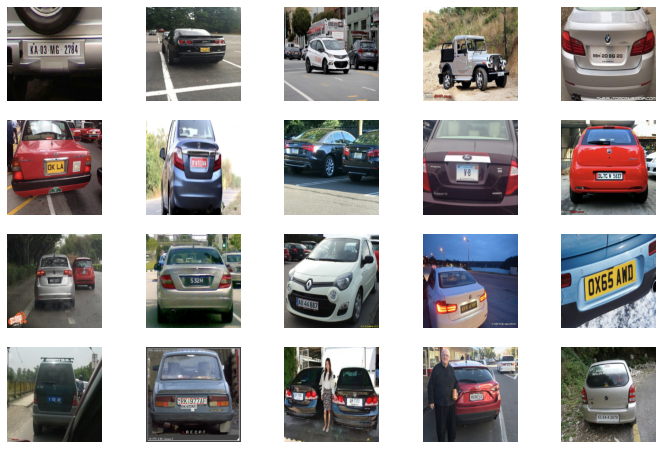

In [7]:
def load_images(limit = None, seed = 0, load=False):
    
    image_paths = glob.glob("/content/drive/My Drive/plate/images/*")
    image_count =  len(image_paths)
    print(f'Found {image_count} images...')
    
    if limit is None or limit > image_count:
        limit = image_count
    if limit < 0:
        return
    np.random.seed(seed)
    image_paths = np.random.choice(image_paths, limit, replace=False)
    
    imgs = []
    if load is True:
        for image_path in image_paths:
            img = preprocess_image(image_path, size=(224, 224))
            imgs.append(img)

    return image_paths, imgs
        
def show_images(imgs, titles=None, grid=(4, 5), figsize=(12, 8)):
    fig = plt.figure(figsize=figsize)

    for i in range(grid[0]*grid[1]):
        if i >= len(imgs):
            return
    
        fig.add_subplot(grid[0], grid[1], i+1)
        plt.axis(False)
        if titles is not None and i < len(titles):
            plt.title(titles[i])
        try:
            if (len(imgs[i].shape) == 2):
                plt.imshow(imgs[i], cmap="gray")    
            else:
                plt.imshow(imgs[i])
        except:
            plt.text(0.5, 0.5, 'Missed', **dict(ha='center', va='center', fontsize=16, color='C1'))
            pass

image_paths, loaded_images = load_images(limit=20, seed=0, load=True)
show_images(loaded_images)

In [10]:
class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    
    
    
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    
    #Non-maximum Suppression 알고리즘을 사용해 bounding box 선택
    
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels

def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

#예측 값에서 영상에서 잘라낸 번호판으로 재구성 기능
def reconstruct(I, Iresized, Yr, lp_threshold):
    #훈련 후 사진이 줄어들기 때문에 훈련할 때 얼마나 축소됐는지를 추정해 훈련 후 픽셀 공간에 다시 적용
    net_stride = 2**4
    #side는 출력된 이미지의 특징이 원본 사진과 같은 크기로 늘어났을 때, 각 셀은 원본 그림의 '한 변 길이'에 관한 것
    #만약 데이터 집합 훈련을 바꾸면, 이 값을 바꾸어 최적의 추정을 얻어야 함
    side = ((208 + 40)/2)/net_stride

    # 한 줄 혹은 두 줄로 구성된 자동차 번호판
    one_line = (470, 110)
    two_lines = (280, 200)

    #모델의 처음 2차원 매개변수는 해당 위치가 번호판의 중심인지 여부
    Probs = Yr[..., 0]
    # 뒤의 6차원은 아핀 변환의 파라미터로, 번호판을 비틀어진 좌표 공간에서 직각 좌표로 되돌리는 데 사용.
    Affines = Yr[..., 2:]

    # 모든 번호판 센터(m, n)
    xx, yy = np.where(Probs > lp_threshold)

    # 실제 훈련 입력에서 그림 크기 가져오기
    WH = getWH(Iresized.shape)
    # 실제 출력 이미지 크기
    MN = WH/net_stride


# 아래의 모든 과정은 평행사변형으로 뒤틀린 번호판을 직사각형으로 되돌리기 위한 것
# 주로 아핀 변환의 사상을 사용하며, 그 매개변수는 모형 훈련에서 직접 얻음
# 그중에는 비교적 미혹적인 어구들이 있는데, 실제로는 손실 함수에 의해 결정.
# 손실 함수는 모델의 훈련 패턴을 결정하는데, 현재 테스트와 재구성 단계는 출력
#이 정확하기 위해서도 이 패턴을 따라야 하며, 모든 조작은 의미 있고, 생략할 수 없음
# 의문이 있는 조작은 원작 논문의 이해에 맞출 수 있음

    vxx = vyy = 0.5
    #예측 결과의 모서리가 왜곡되지 않은 범위(이미지 공간에 실제로 존재하지 않는 직각 좌표)를 나타냄
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    #각 번호판 중앙에 대해 훈련에서 얻은 아핀 변환 매개변수를 사용하여 직각 좌표의 번호판 위치를 복원.
    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        #번호판 위치를 추정하는 파라미터 아래의 파라미터 그룹 A가 생성되는데, 이 형식은 모델 훈련 시 직접 규정한 것
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        
        # 번호판 교정 후 위치를 추정하는 파라미터는 아래의 파라미터 그룹 B에 의해 생성되며, 이 형식도 모델 훈련 시 직접 규정
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)
        
        # 각도점 좌표를 복원
        pts = np.array(A*base(vxx, vyy))
        # 번호판 교정 후의 위치를 복원
        pts_frontal = np.array(B*base(vxx, vyy))

        # 좌표 정규화
        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    # 겹치는 검출상자 중에서 가장 좋은 것을 선별
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # 가로세로비에서 한 줄인가 두 줄인가 확인
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            #출력 크기
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            # 정규화된 좌표를 원본 그림 좌표에 적용
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            # cv2에서 인식할 수 있는 변환 행렬 생성
            H = find_T_matrix(ptsh, t_ptsh)
            # 복원한 자동차 번호판 사진을 추출
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            
            TLp.append(Ilp)
            Cor.append(ptsh)
            
    return final_labels, TLp, lp_type, Cor

def detect_lp(model, I, max_dim, lp_threshold):
#max_dim을 인수하여 사이즈 조정을 계속 완료
# 여기서 조정은 또한 로더에 재단하기 위해 입력된 그림만을 위한 것
# 전체 그림을 입력한 경우 효과를 알 수 없음
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    # 모형예측
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    
    # 모형 결과로부터 번호판 위치와 정면 시야각도를 재구성
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor

In [12]:
def get_plate(image_path, Dmax=608, Dmin=256):

# 만약 입력된 것이 적재구에 재단된 그림이라면, 이러한 확대·축소 처리는 측면 번호판의 검출을 더욱 효과적으로 할 수 있음
# 원본 배경 그림을 입력한 경우 이러한 처리도 수행되지만 의미가 없음
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    
    return LpImg, cor

1/1 [==============================] - 1s 1s/step
Detect 1 plate(s) in Cars274


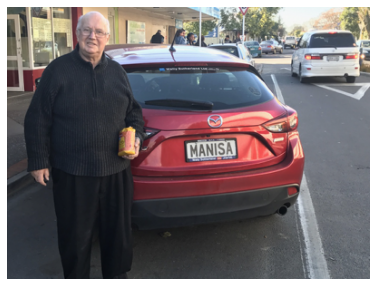

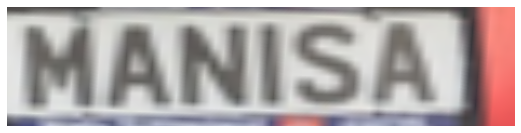

In [14]:
test_image = image_paths[18]
LpImg, cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg), splitext(basename(test_image))[0])

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))

show_images(LpImg, grid=(1,2), figsize=(20,5))

In [ ]:
def get_boxs(cor):
    pts=[]  
    x_coordinates=cor[0]
    y_coordinates=cor[1]
    # 저장 순서: 왼쪽 위, 오른쪽 위, 왼쪽 아래, 오른쪽 아래
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    return pts.reshape((-1,1,2))

def draw_boxs(image_path, cors, thickness=3): 
    pts=[] 
    
    for cor in cors:
        pts.append(get_boxs(cor))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image, pts,True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_boxs(test_image, cor))

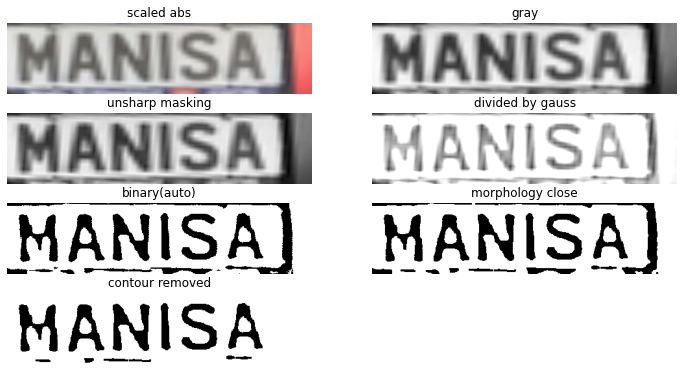

In [15]:
def remove_contour(src):
    cnts = cv2.findContours(src, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    mask = np.zeros(src.shape, dtype=np.uint8)
    cv2.fillPoly(mask, cnts, [255,255,255])
    mask = 255 - mask
    return cv2.bitwise_or(src, mask)
    
    
def sharpen(src):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2d(src=src, ddepth=-1, kernel=kernel)

def unsharp_masking(src):
    gauss1 = cv2.GaussianBlur(src, (0,0), 2.0)
    return cv2.addWeighted(src, 1.5, gauss1, -0.5, 0.0)
    
def morphology_close(src):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    return cv2.morphologyEx(src, cv2.MORPH_CLOSE, kernel)

def divide_by_gauss(src):
    gauss2 = cv2.GaussianBlur(src, (0,0), 10.0)
    return cv2.divide(src, gauss2, scale=255)
    
def enhance_contrast(src):
    return cv2.equalizeHist(src)

def binary(src, thresh = -1):
    if thresh > 0:
        return cv2.threshold(src, thresh, 255, cv2.THRESH_BINARY)[1]
    else:
        (thresh, image_bin) = cv2.threshold(src, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        return image_bin
    

def filter_images(images, debug=False):
    images_with_title = []
    image_src = images[0]
    
    image_bag = []
    title_bag = []
    image_bag.append(cv2.convertScaleAbs(image_src, alpha=(255.0)))
    title_bag.append("scaled abs")
    # gray
    image_bag.append(cv2.cvtColor(image_bag[-1], cv2.COLOR_BGR2GRAY))
    title_bag.append("gray")
    
    # unsharp mask
    image_bag.append(unsharp_masking(image_bag[-1]))
    title_bag.append("unsharp masking")
    
    # divided by gauss
    image_bag.append(divide_by_gauss(image_bag[-1]))
    title_bag.append("divided by gauss")
    
    # binary
    image_bag.append(binary(image_bag[-1]))
    title_bag.append("binary(auto)")
    
    # apply morphology
    image_bag.append(morphology_close(image_bag[-1]))
    title_bag.append("morphology close")

    # remove contour
    image_bag.append(remove_contour(image_bag[-1]))
    title_bag.append("contour removed")

    # or... crop
#     image_bag.append(image_bag[-1].copy())
#     title_bag.append("cropped")
#     image_bag[-1][0:25]=255
#     image_bag[-1][image_bag[-1].shape[0]-32:image_bag[-1].shape[0]]=255
#     image_bag[-1][:,0:55]=255
#     image_bag[-1][:,image_bag[-1].shape[1]-10:image_bag[-1].shape[1]]=255
    

    
    if debug:
        show_images(image_bag, title_bag, grid=(5,2))
        
    return image_bag
    
filtered_images = filter_images(LpImg, debug=True)

In [17]:
#!export TESSDATA_PREFIX="/usr/share/tesseract-ocr/"

In [ ]:
#sudo apt-get install tesseract-ocr-kor

MANISA



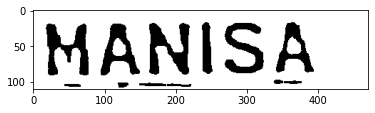

In [22]:
# 문자인식 검은 글씨와 흰 배경 출력시 결과값이 높음
# plt.imshow(img_dilation)
# Mask =cv2.bitwise_not(thre_mor)
Mask = filtered_images[-1]
plt.imshow(Mask,cmap="gray")
print(pytesseract.image_to_string(Mask, config="--psm 7"))

Found 433 images...
1/1 [==============================] - 0s 262ms/step
9 in 60 missed


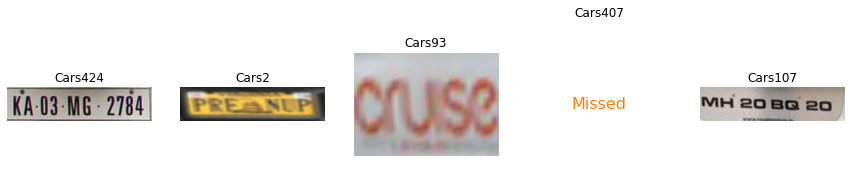

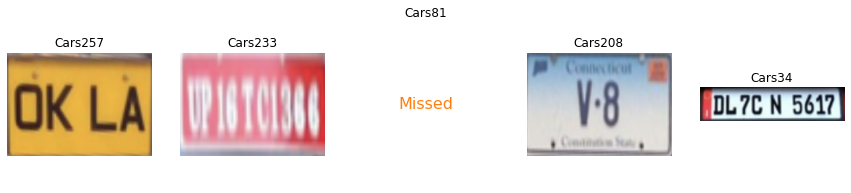

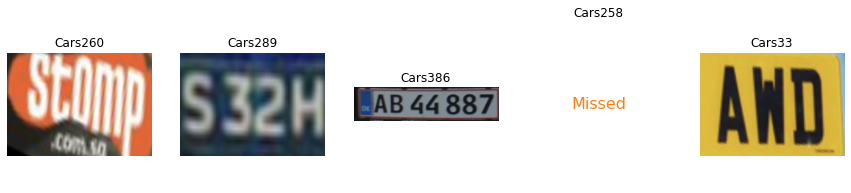

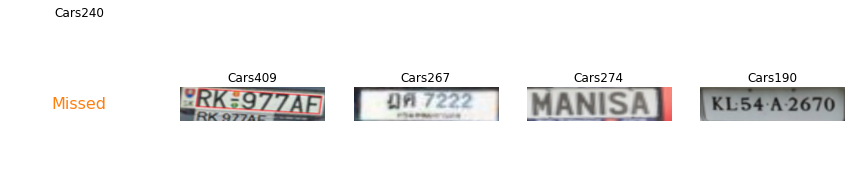

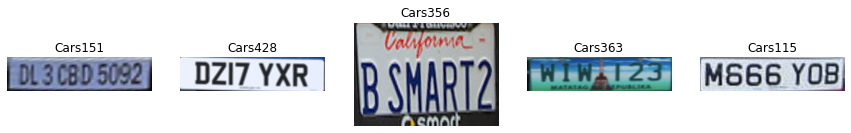

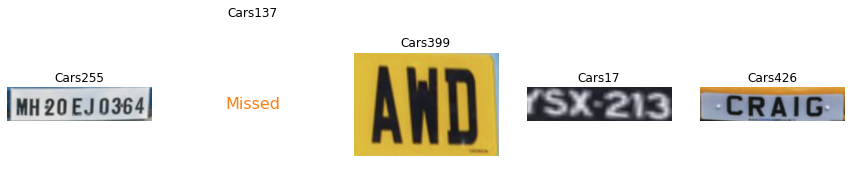

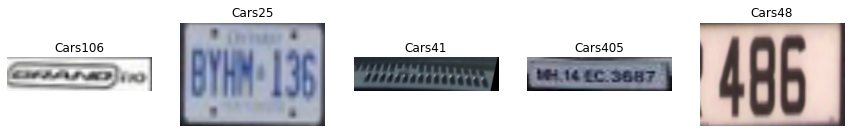

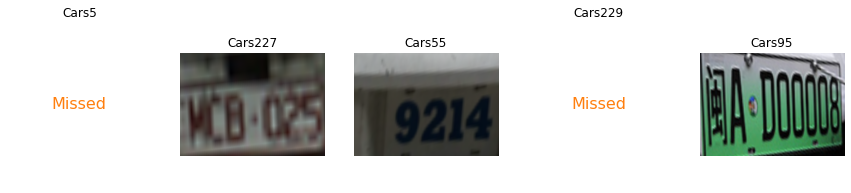

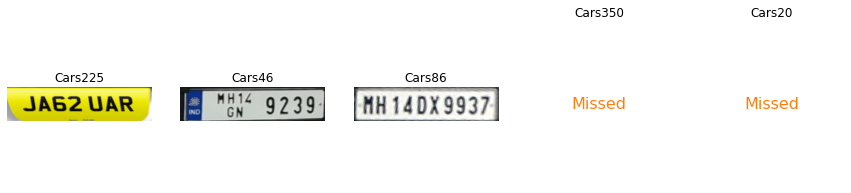

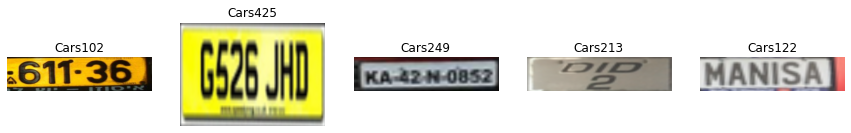

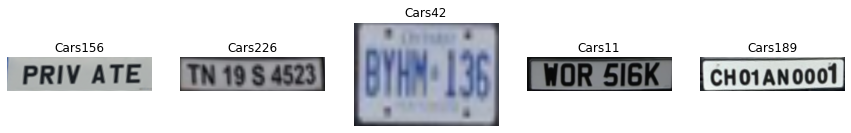

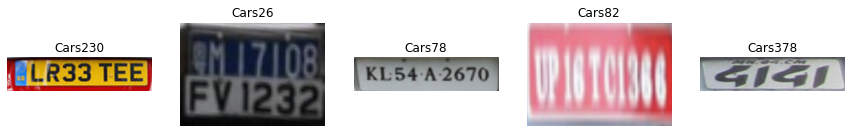

In [23]:
test_num = 60
image_paths, loaded_images = load_images(limit=test_num, seed=0)
images = []
titles = []
missed = 0
for i in range(test_num):   
    image_path = image_paths[i]
    try:
        LpImg, _ = get_plate(image_path)
    except:
        missed += 1
        images.append(None)
    else:
        images.append(LpImg[0])
    titles.append(splitext(basename(image_path))[0])
    
col = 5
print(f'{missed} in {test_num} missed')
for i in range(int((test_num-1)/col+1)):
    i=i*col
    show_images(images[i:i+col:], titles[i:i+col:], grid=(1,5), figsize=(15,3))

In [ ]:
#화상 처리는 모두 자동 파라미터를 사용하기 때문에, 처리 결과는 비교적 괜찮음

Found 433 images...
1/1 [==============================] - 0s 478ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 624ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 388ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 390ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 288ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 371ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 599ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 671ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 519ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 486ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 597ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 306ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 586ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 582ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 409ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 276ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 385ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 460ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 194ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 565ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 274ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 450ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 279ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 276ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 827ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 374ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 594ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 287ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 402ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 511ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 600ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 289ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 292ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


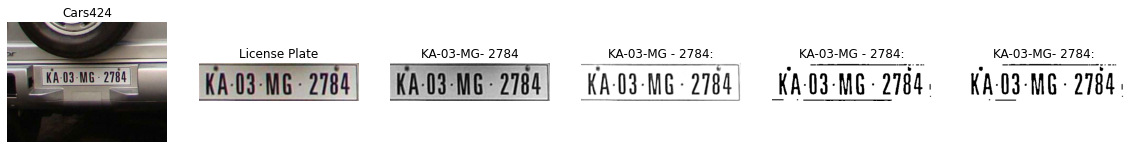

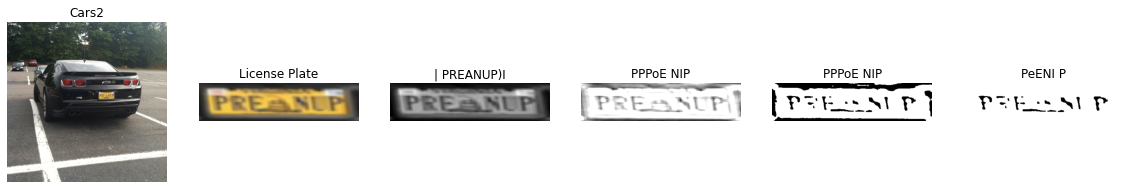

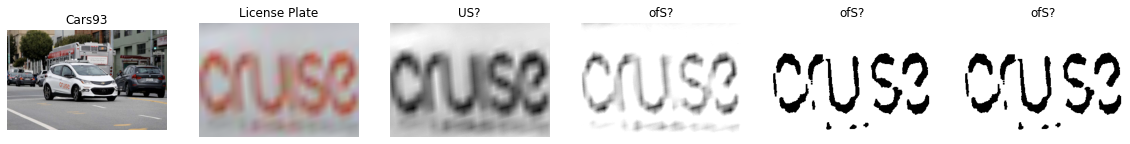

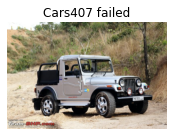

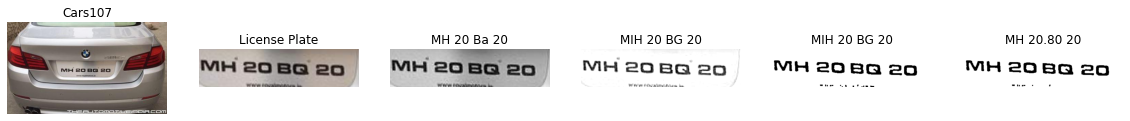

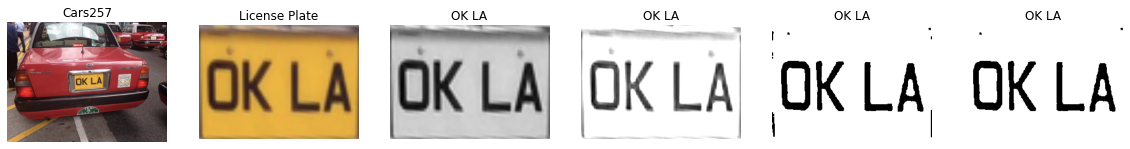

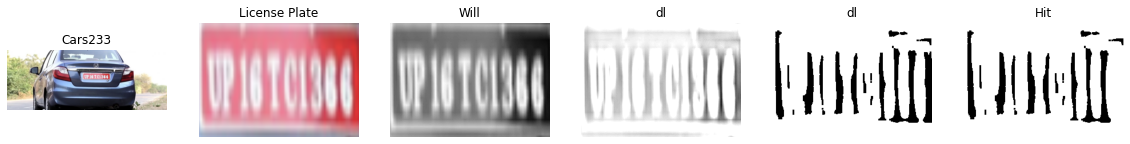

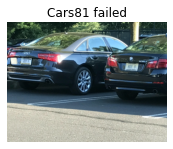

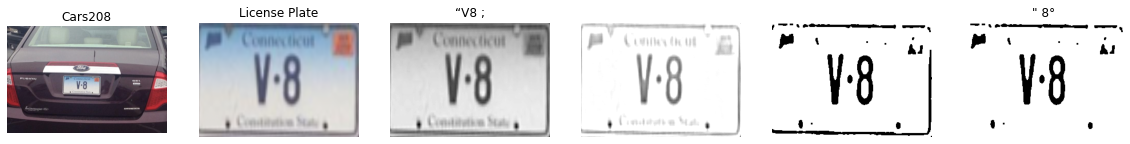

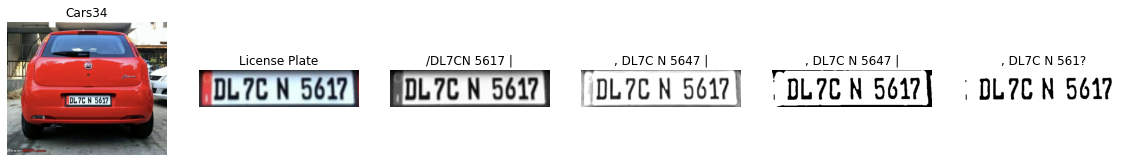

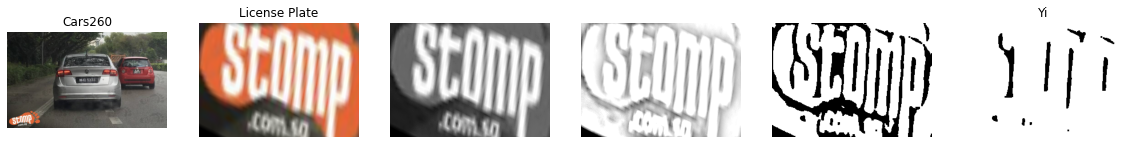

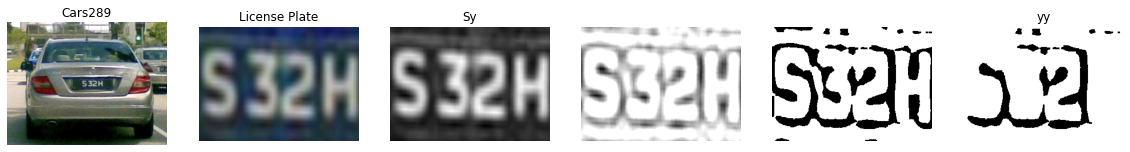

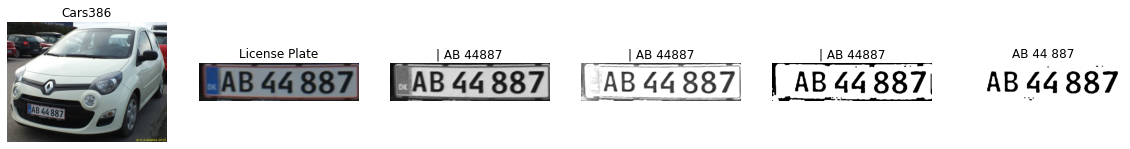

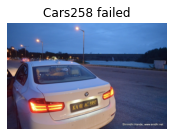

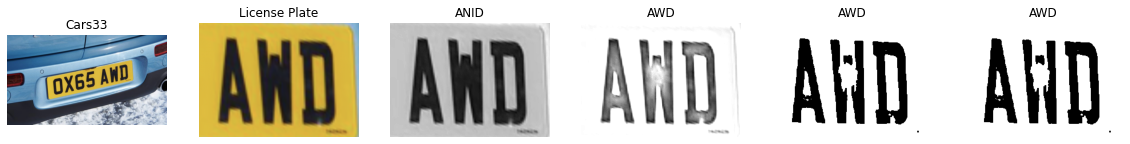

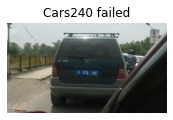

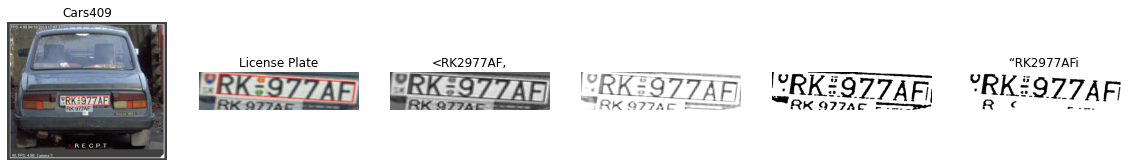

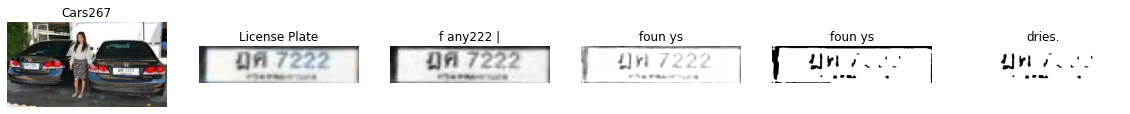

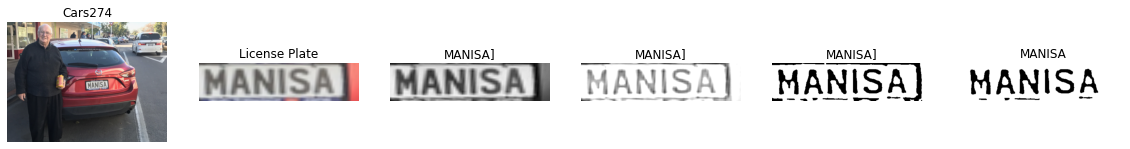

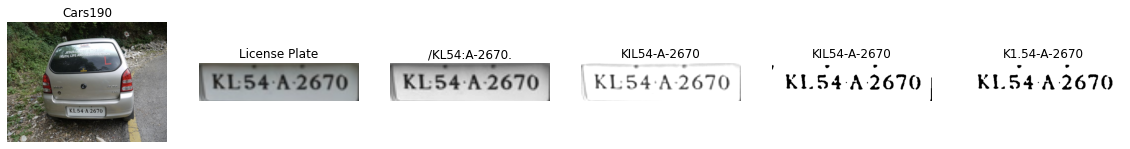

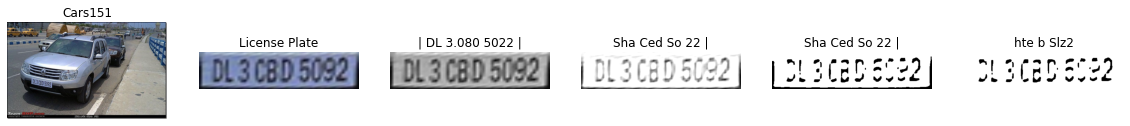

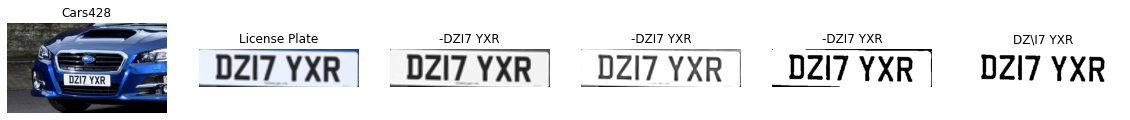

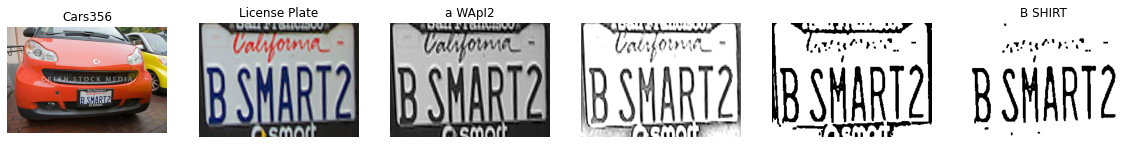

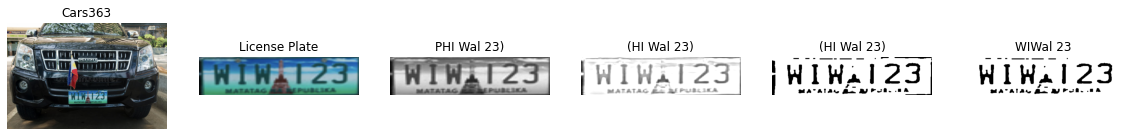

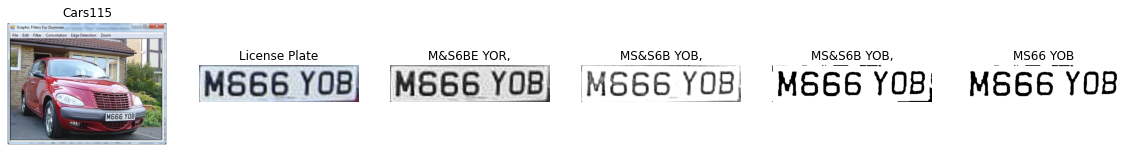

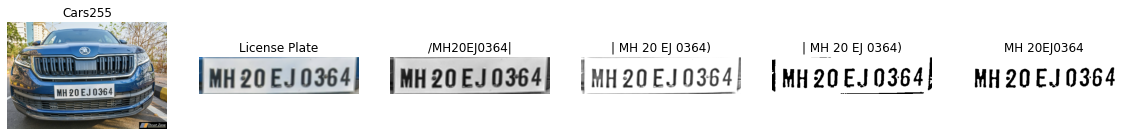

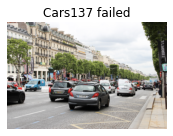

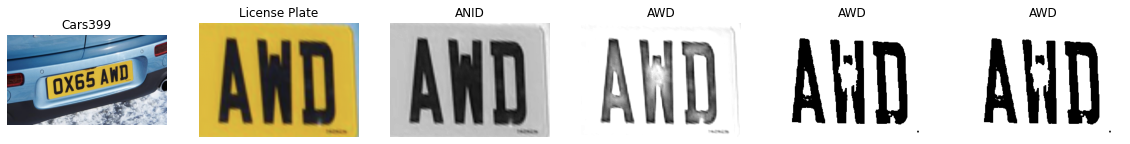

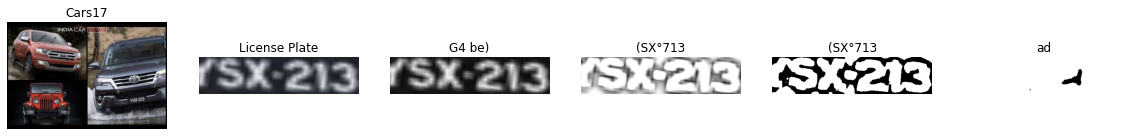

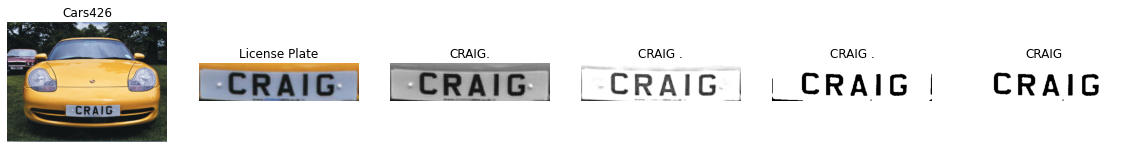

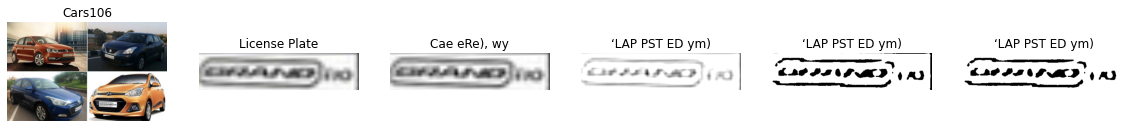

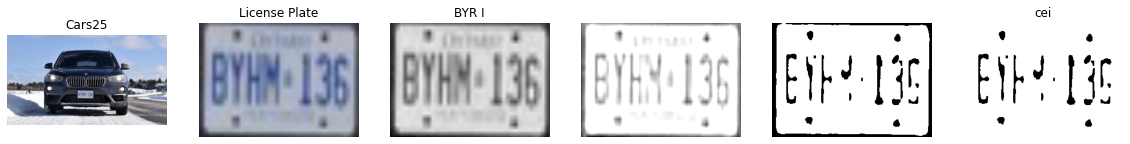

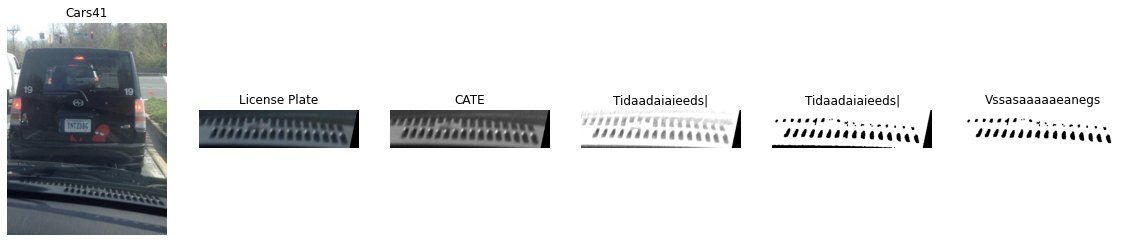

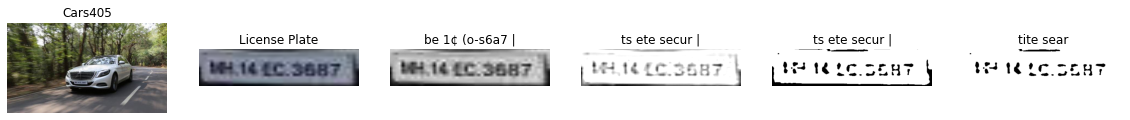

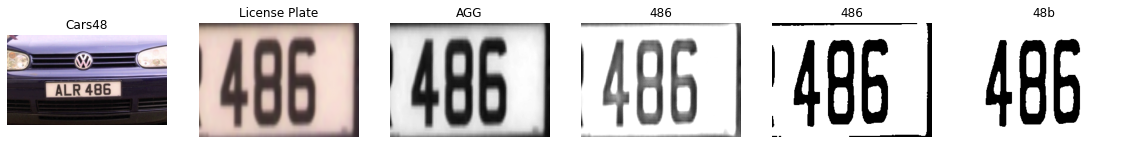

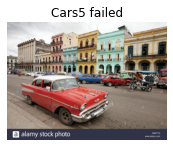

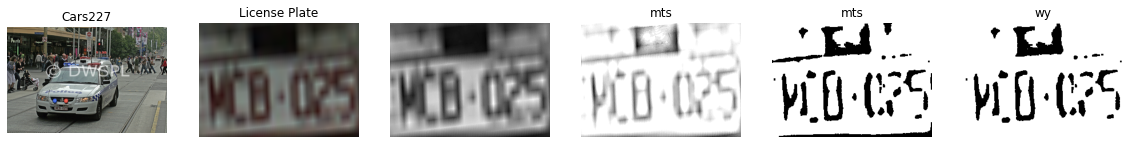

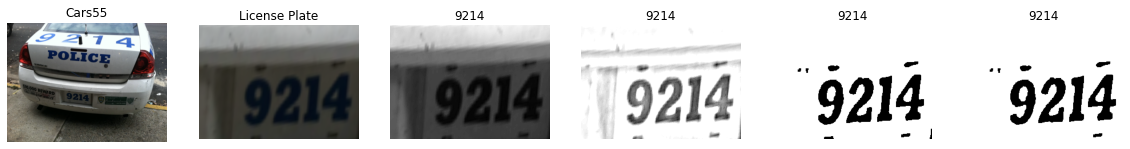

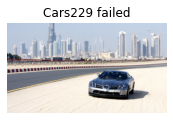

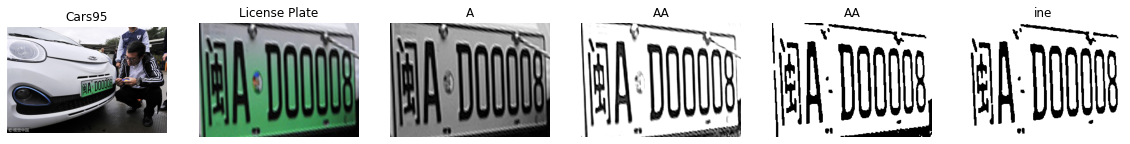

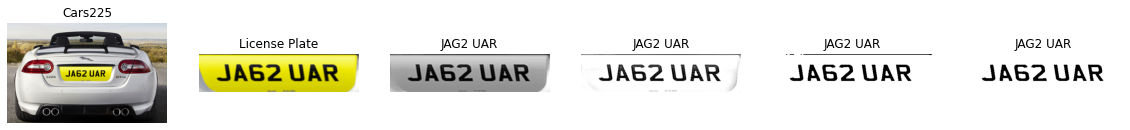

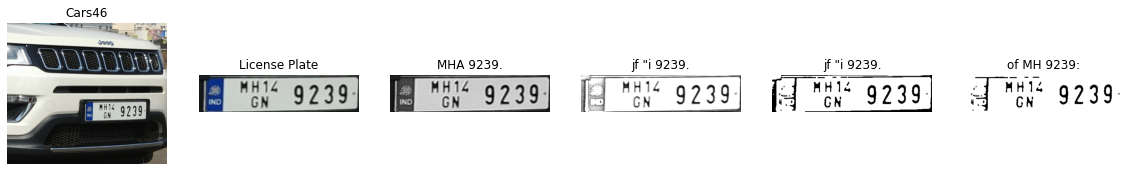

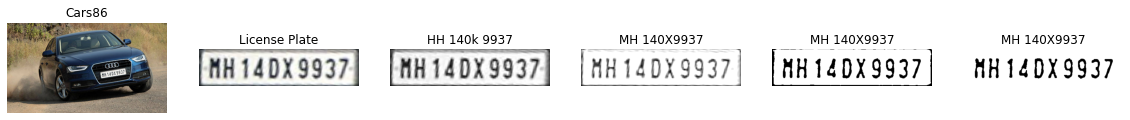

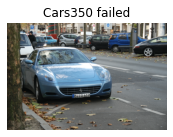

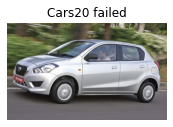

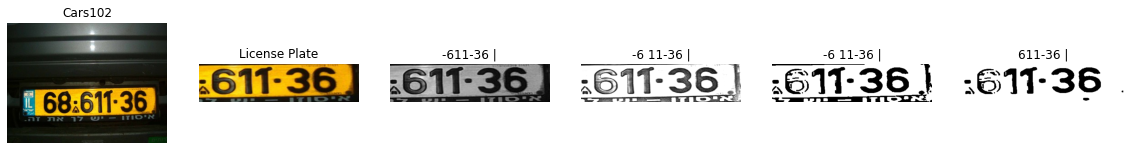

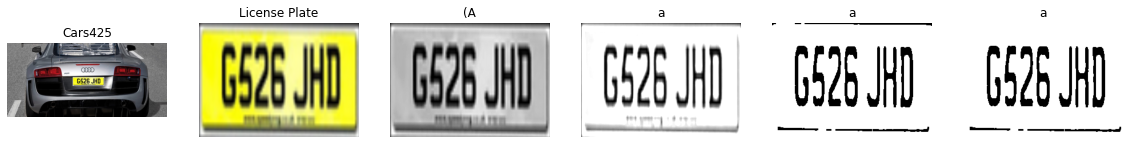

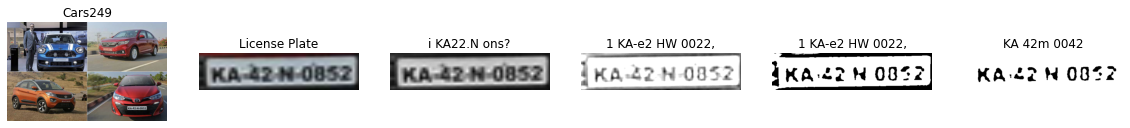

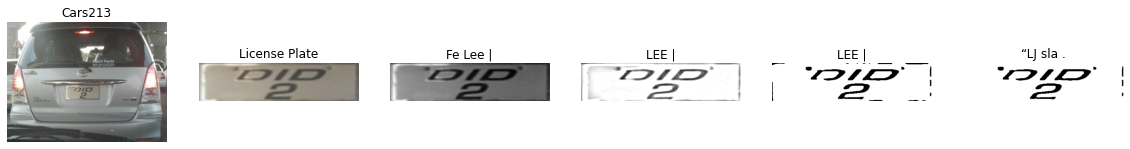

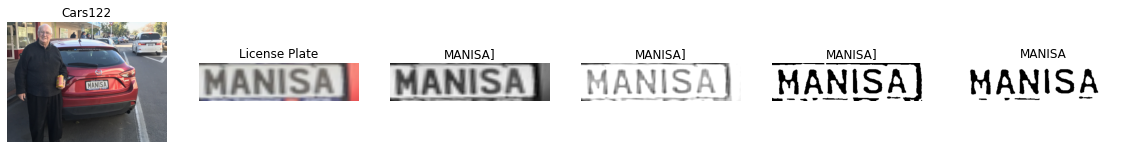

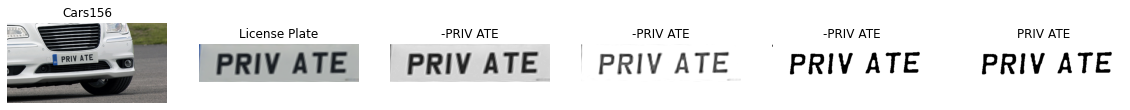

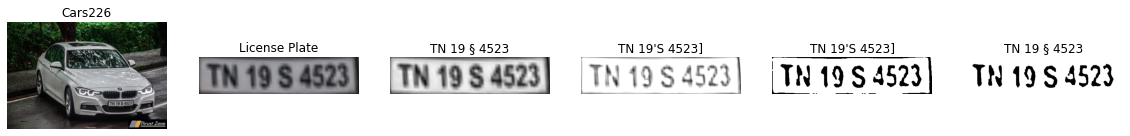

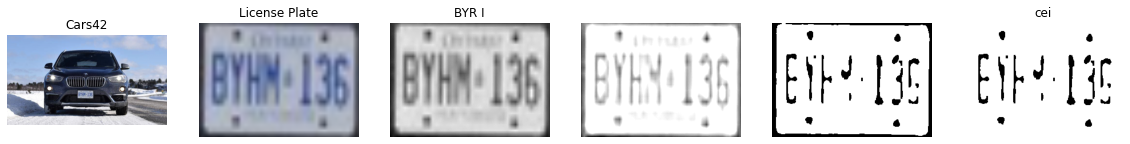

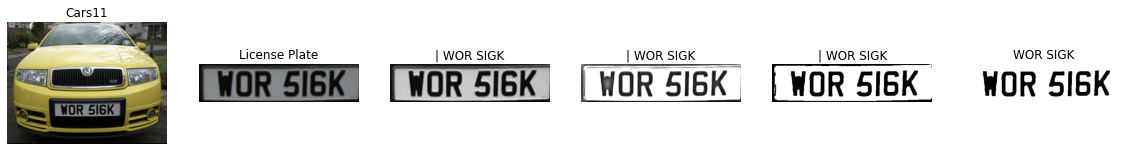

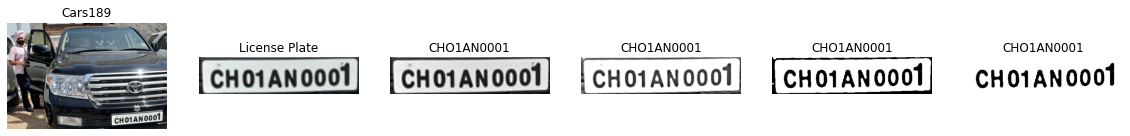

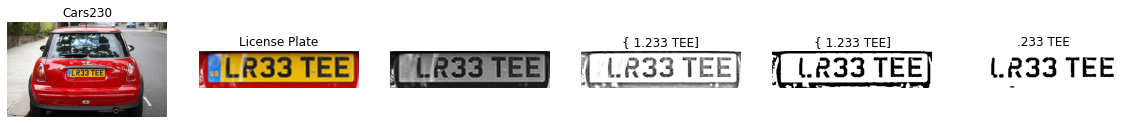

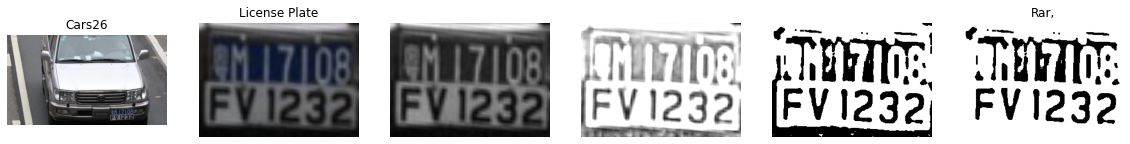

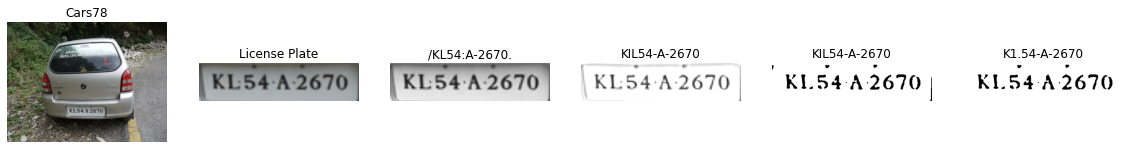

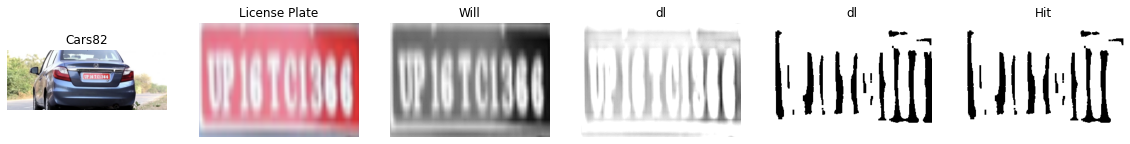

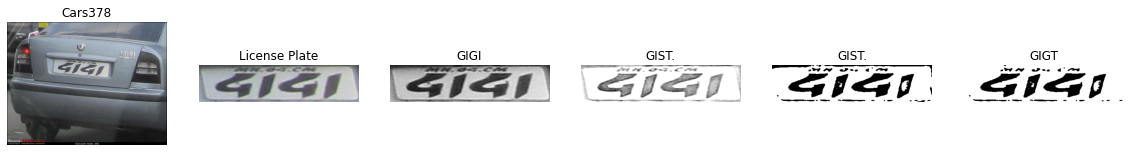

In [24]:
def one_item(image_path):
    def s(img):
        a = pytesseract.image_to_string(img, config='--psm 7')[:-1].strip()
        return a
    try:
        LpImg, _ = get_plate(image_path)
    except:
        show_images([preprocess_image(image_path)],[splitext(basename(image_path))[0] + ' failed'], grid=(1,6), figsize=(20,6))
        return
    imgs = filter_images(LpImg)
    
    show_images([preprocess_image(image_path), LpImg[0], imgs[2], imgs[3], imgs[-2], imgs[-1]],
                [splitext(basename(image_path))[0], "License Plate", s(imgs[3]),s(imgs[5]),s(imgs[-2]),s(imgs[-1])], grid=(1,6), figsize=(20,6))

test_num = 60
image_paths, loaded_images = load_images(limit=test_num, seed=0)
for i in range(test_num):   
    one_item(image_paths[i])